##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2.57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

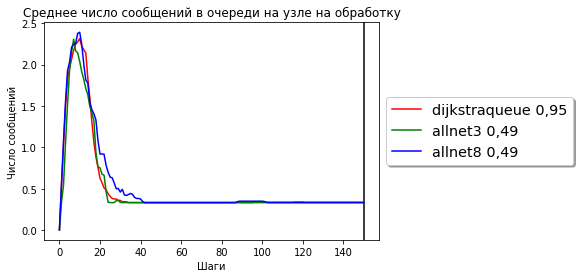

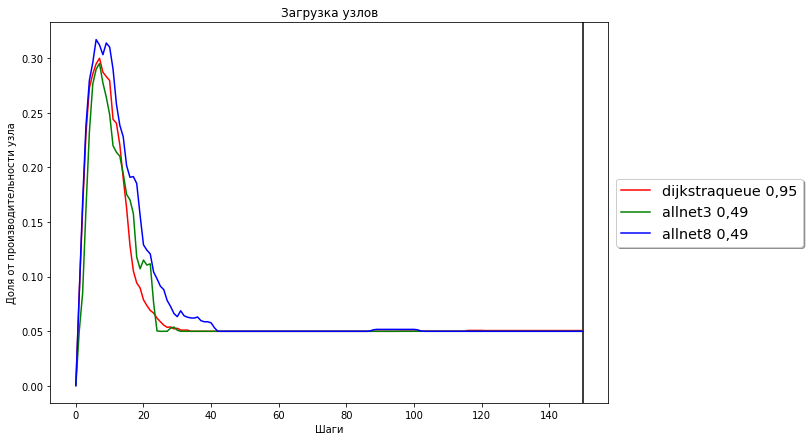

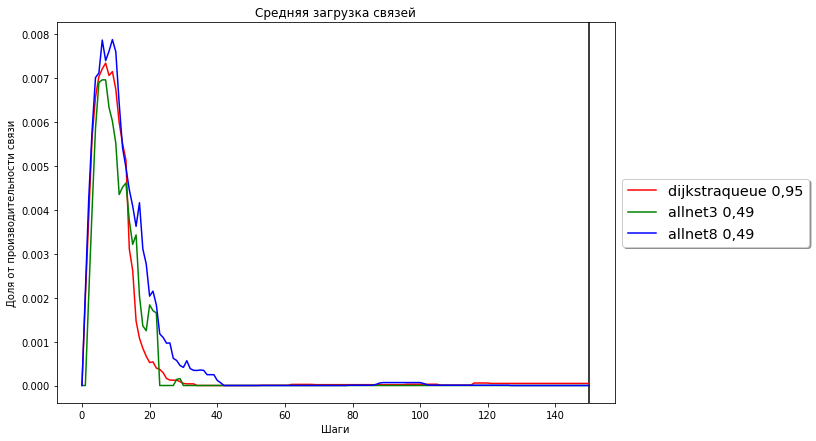

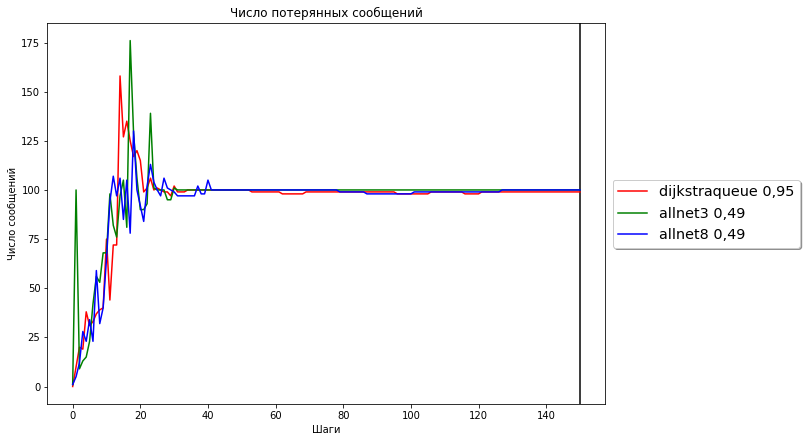

Доставлено 693 Потеряно 95.3803% -dijkstraqueue 0,95
Доставлено 499 Потеряно 96.6736% -allnet3 0,49
Доставлено 756 Потеряно 94.9603% -allnet8 0,49


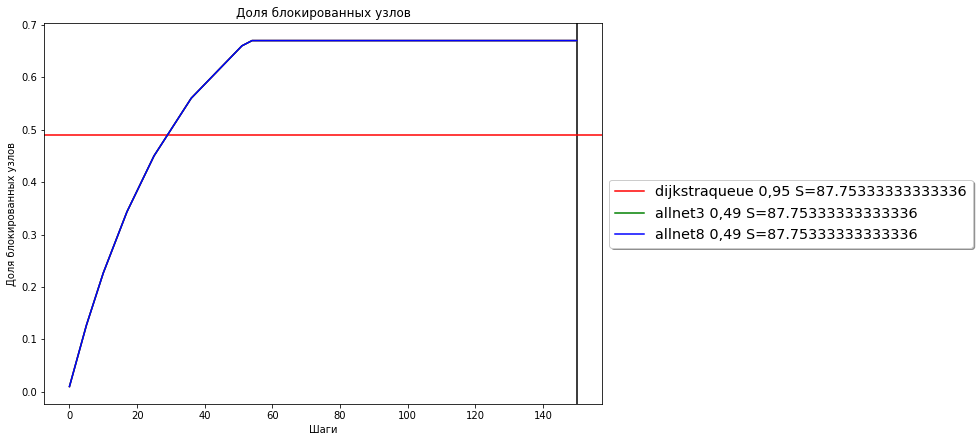

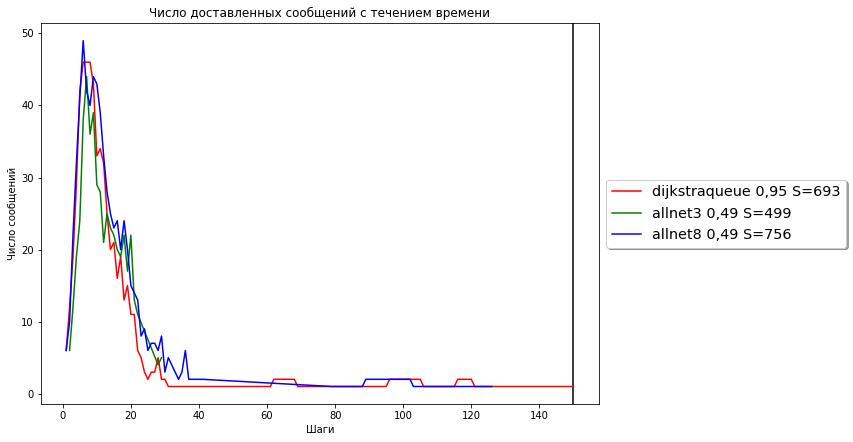

In [2]:
quantity = 100;
log_tags = [
{"tag":  "81e1fdad-c4ff-4fda-b85b-f48b6671e5a6", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "46a2f9a4-73b8-4f61-b42a-bfeb25390fee", "label": "allnet3 0,49", "color": "green"},
{"tag":  "7e71e722-a189-4928-9944-0b3f6e2c965c", "label": "allnet8 0,49", "color": "blue"},

]                        
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

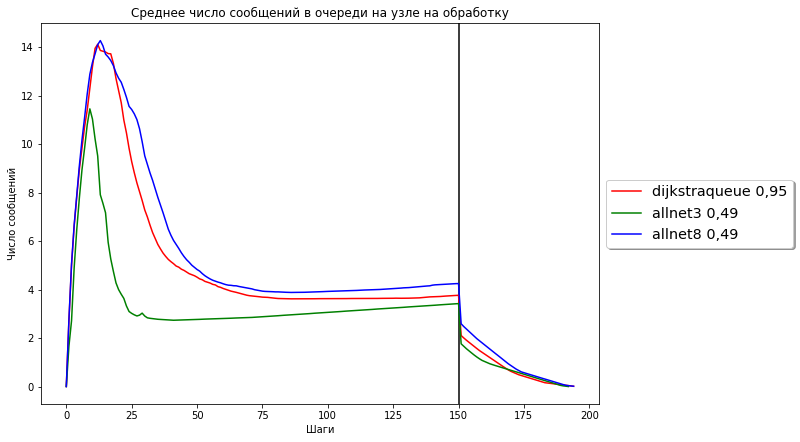

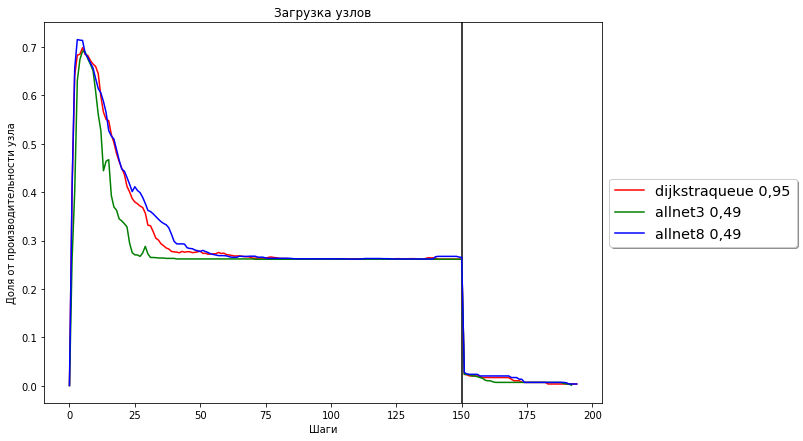

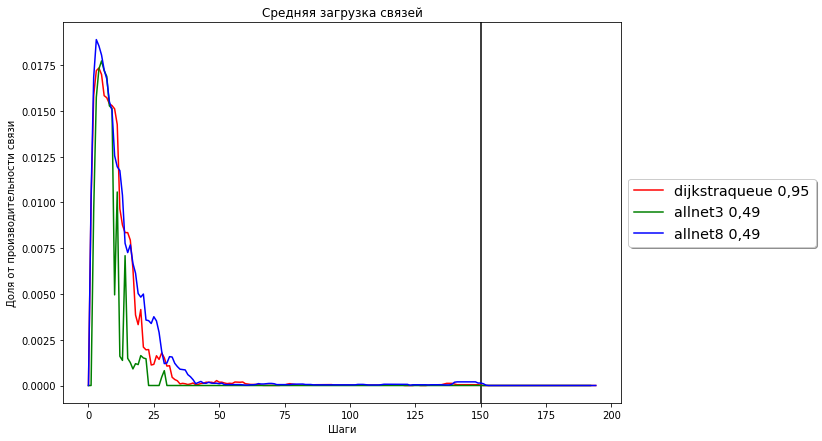

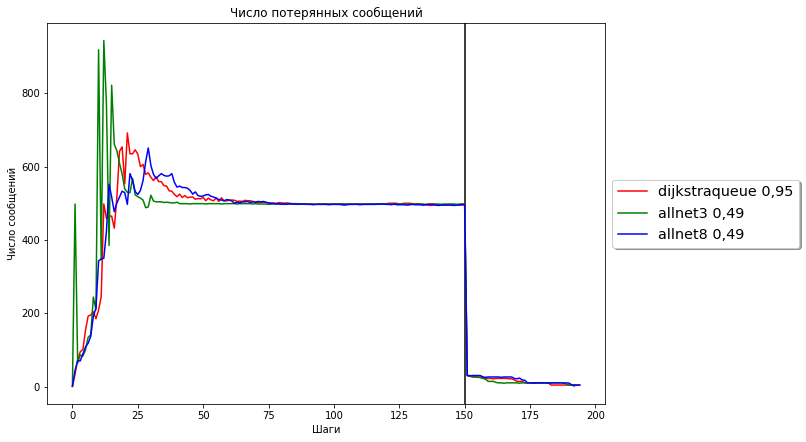

Доставлено 1185 Потеряно 98.4200% -dijkstraqueue 0,95
Доставлено 679 Потеряно 99.0947% -allnet3 0,49
Доставлено 1457 Потеряно 98.0574% -allnet8 0,49


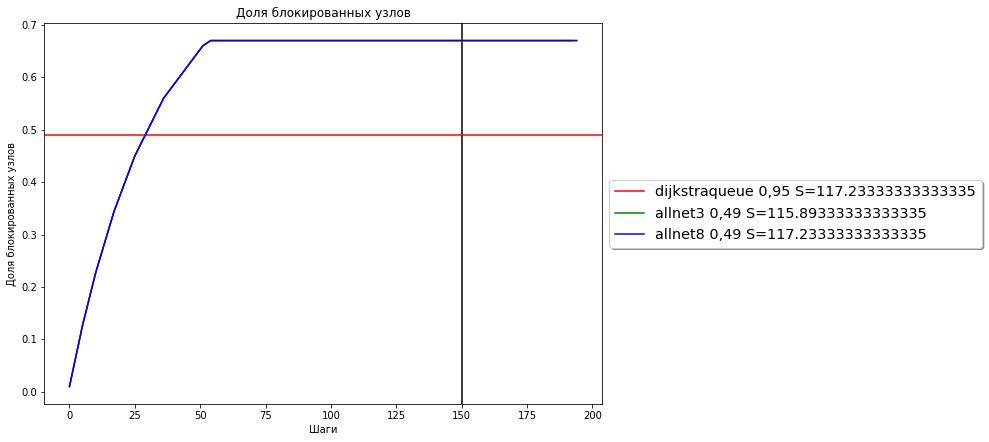

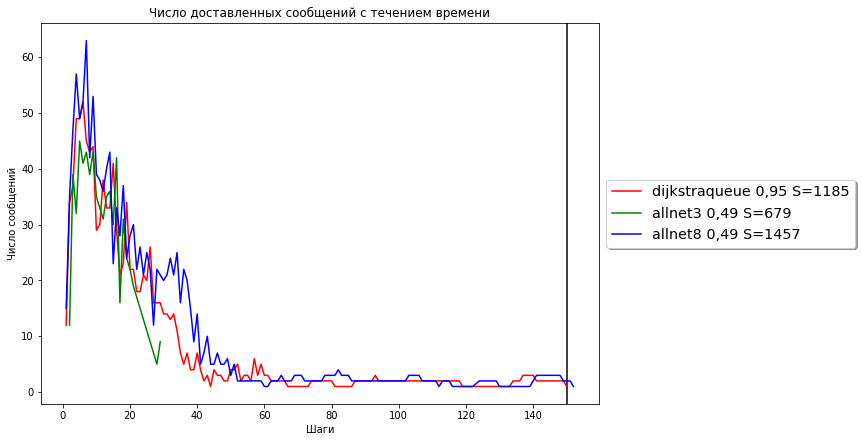

In [3]:
quantity = 500;
log_tags = [
{"tag":  "6fa66091-e57b-420b-b51c-c4548eb129a4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "14082b88-bd73-48ec-a0f3-dd68f6ca54d3", "label": "allnet3 0,49", "color": "green"},
{"tag":  "1dae7fd5-0ed4-441a-8554-ff20b321ec89", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

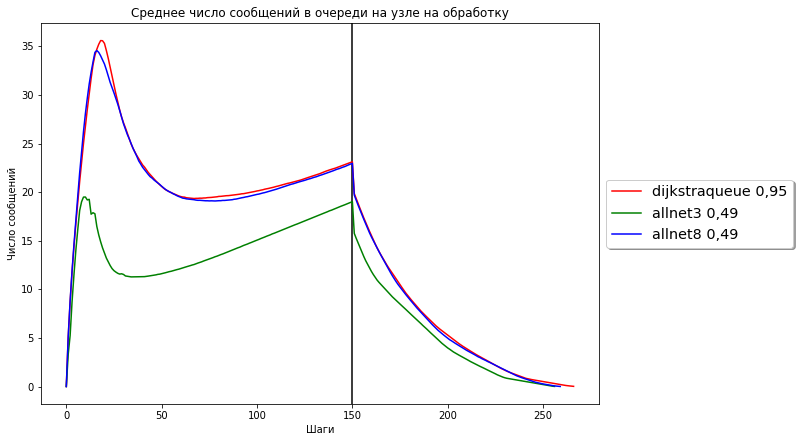

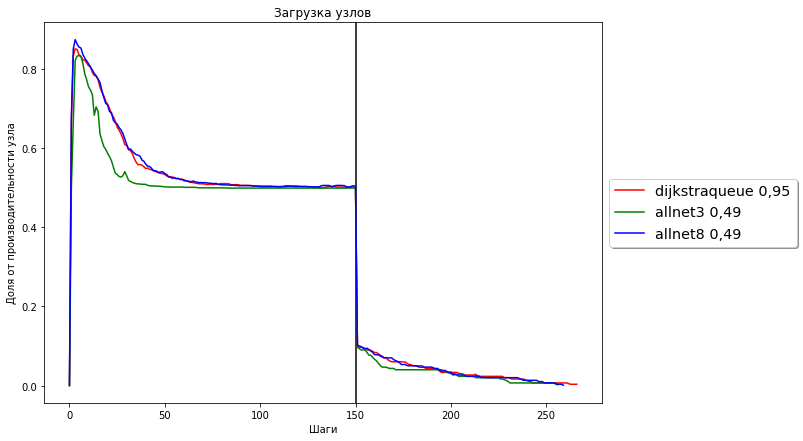

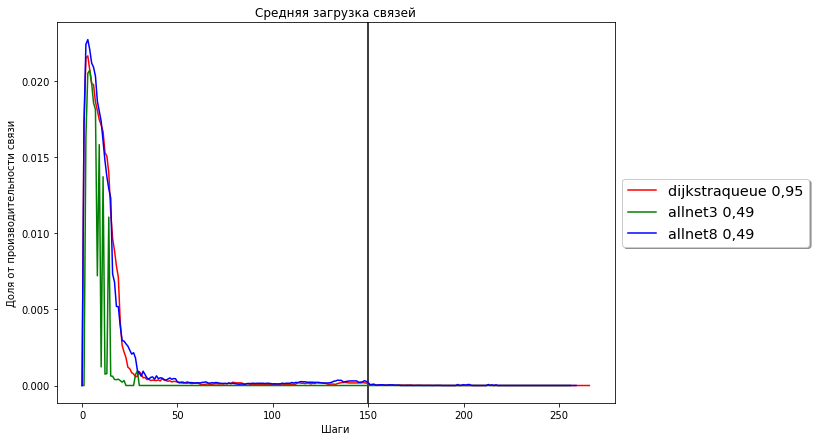

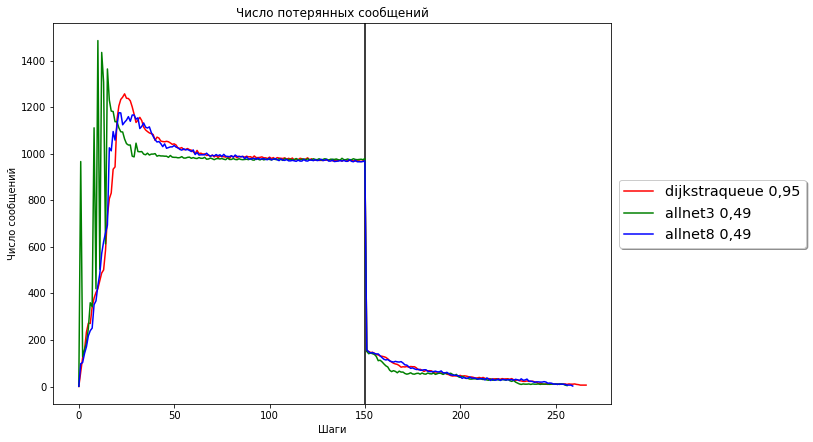

Доставлено 1712 Потеряно 98.8587% -dijkstraqueue 0,95
Доставлено 565 Потеряно 99.6233% -allnet3 0,49
Доставлено 2113 Потеряно 98.5913% -allnet8 0,49


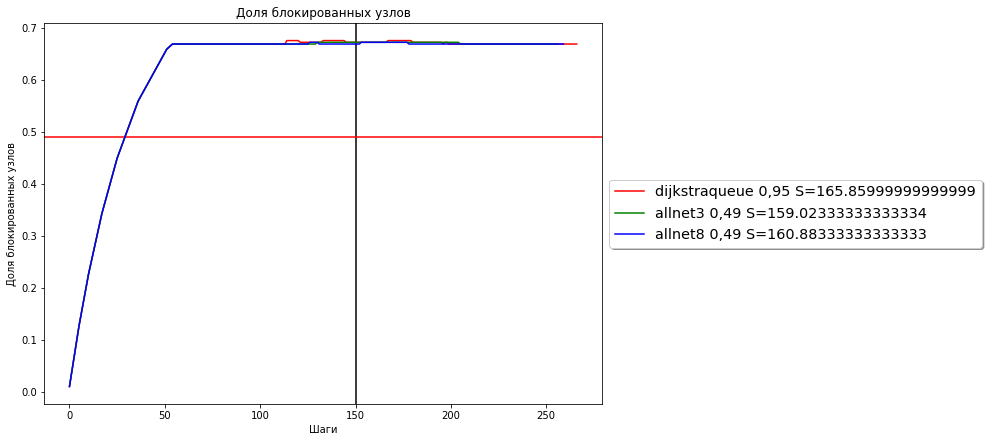

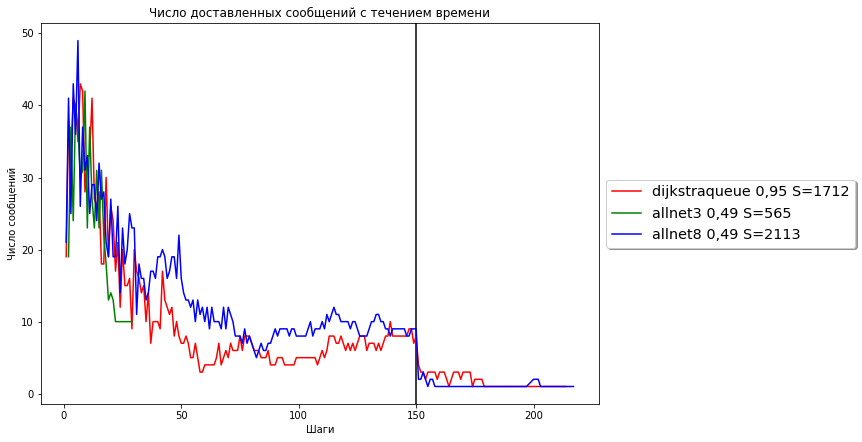

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "9be593ad-e345-4d5f-ba83-b70d3295fa1d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7f615ba2-a851-4563-ba3b-a7449f8d11a1", "label": "allnet3 0,49", "color": "green"},
{"tag":  "88a9dbbe-1847-4097-a1b1-0c1281bba4d6", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

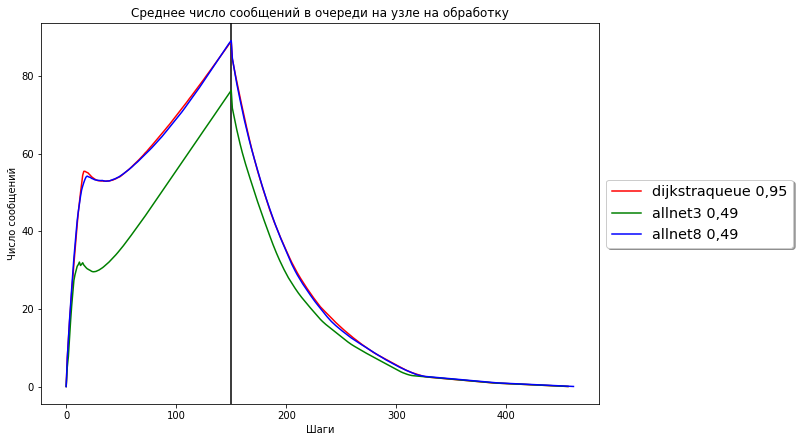

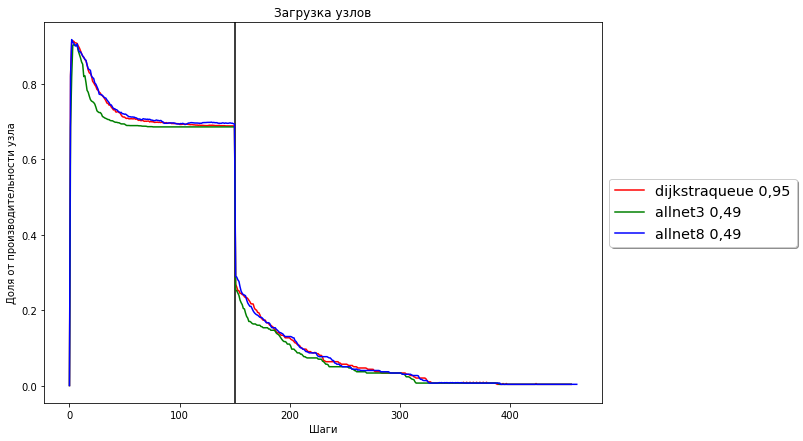

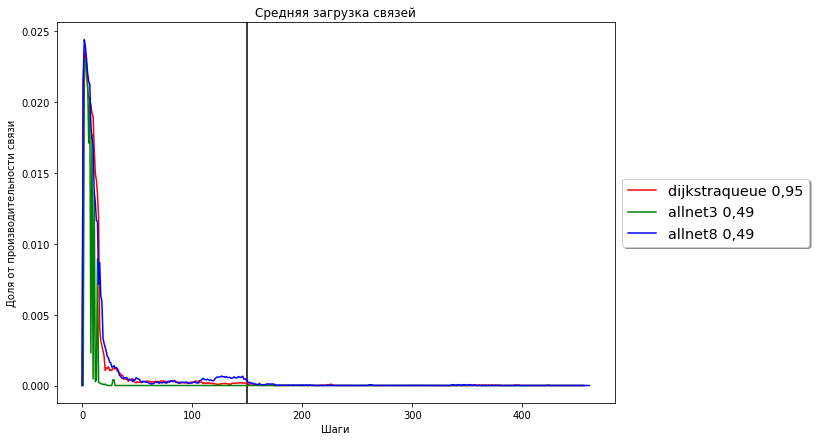

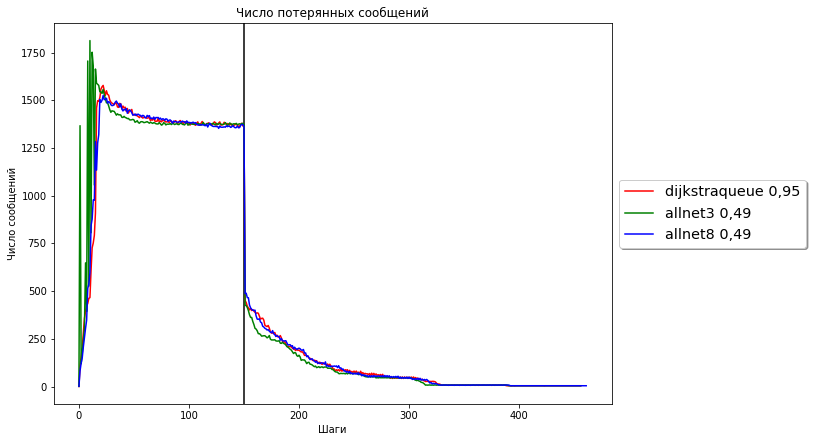

Доставлено 2122 Потеряно 99.0569% -dijkstraqueue 0,95
Доставлено 416 Потеряно 99.8151% -allnet3 0,49
Доставлено 2482 Потеряно 98.8969% -allnet8 0,49


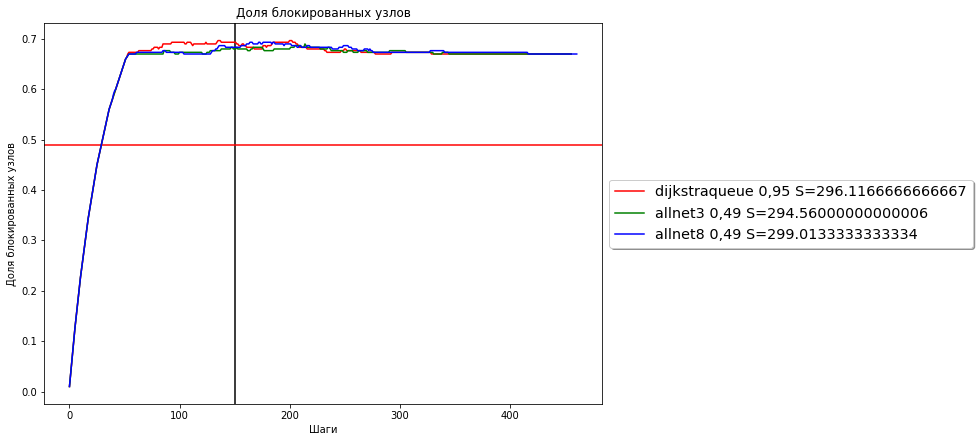

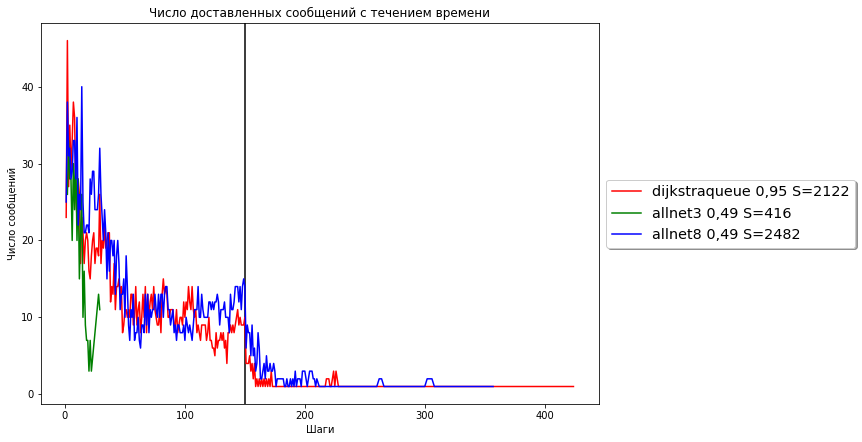

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "6e8e0d64-a7e5-48e4-8b86-82a7b5fa14f4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "3962bcab-b1cf-4b66-908d-abd27653c63f", "label": "allnet3 0,49", "color": "green"},
{"tag":  "84ad7c10-73f3-4274-89af-87e1507b499a", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 1127 Потеряно 97.4956% -dijkstraqueue 0,95
Доставлено 700 Потеряно 98.4445% -allnet3 0,49
Доставлено 1037 Потеряно 97.6956% -allnet8 0,49


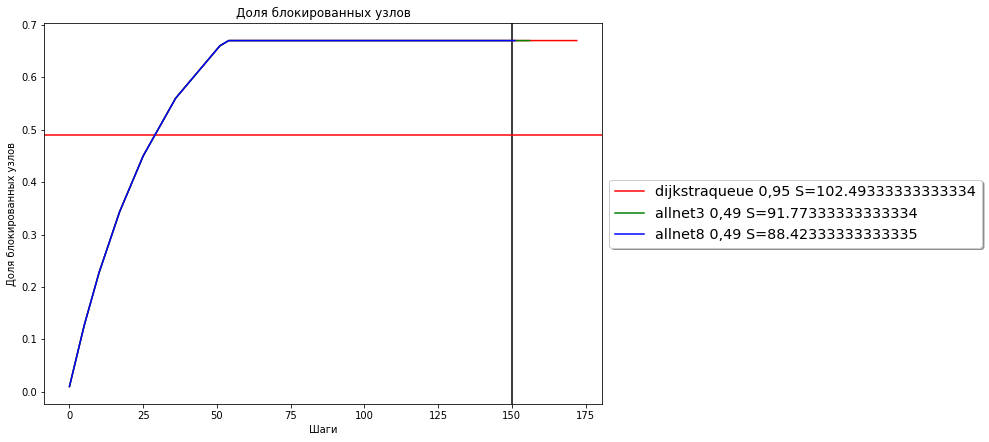

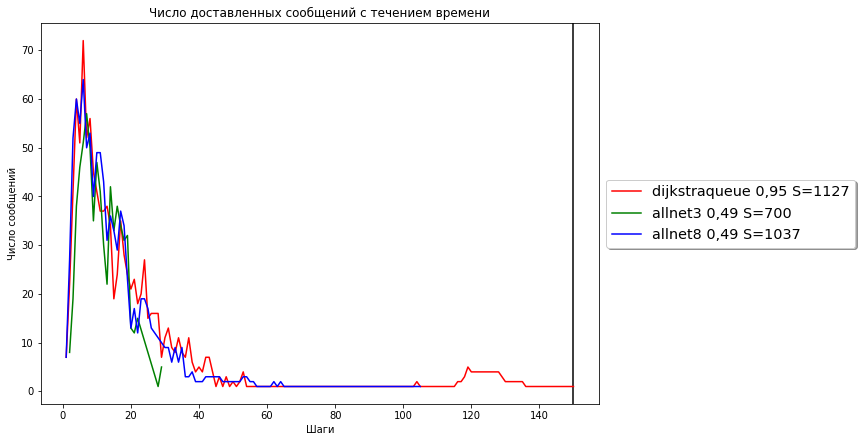

Доставлено 1773 Потеряно 98.3114% -dijkstraqueue 0,95
Доставлено 511 Потеряно 99.5133% -allnet3 0,49
Доставлено 1894 Потеряно 98.1962% -allnet8 0,49


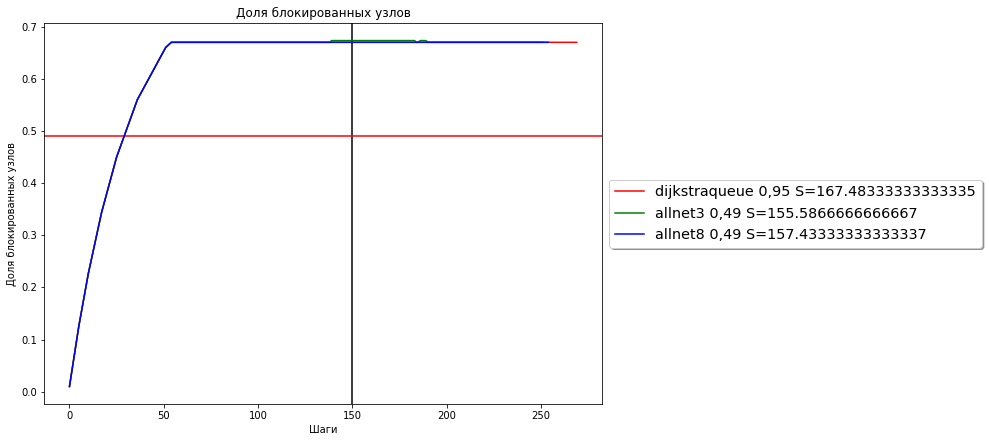

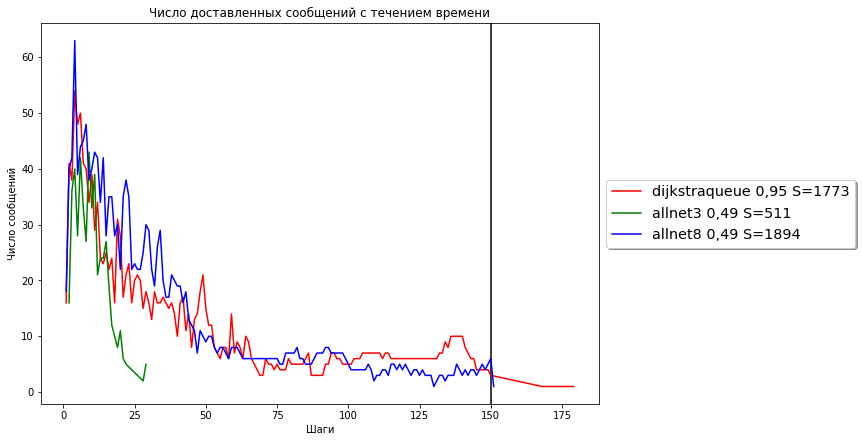

Доставлено 1680 Потеряно 98.7556% -dijkstraqueue 0,95
Доставлено 622 Потеряно 99.5393% -allnet3 0,49
Доставлено 1992 Потеряно 98.5245% -allnet8 0,49


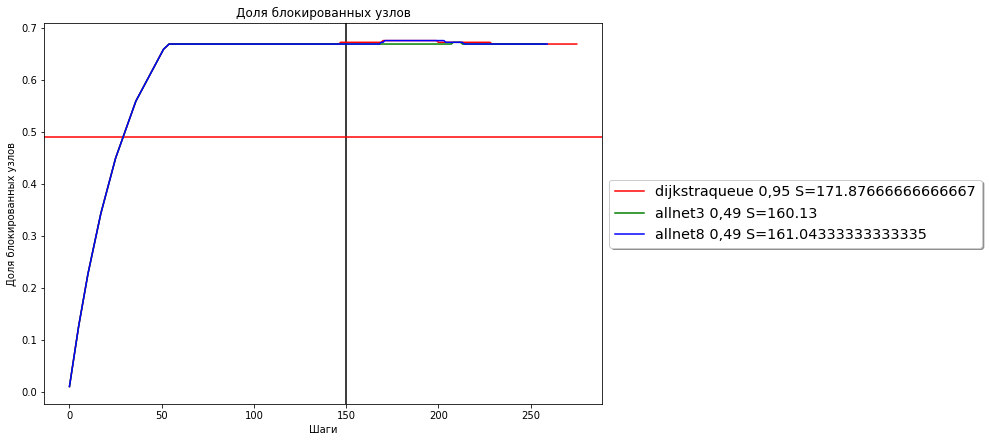

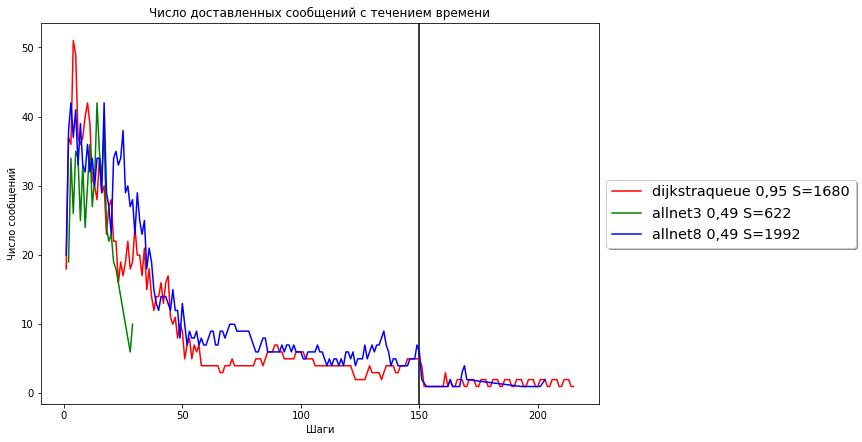

Доставлено 2619 Потеряно 98.6569% -dijkstraqueue 0,95
Доставлено 534 Потеряно 99.7262% -allnet3 0,49
Доставлено 2210 Потеряно 98.8667% -allnet8 0,49


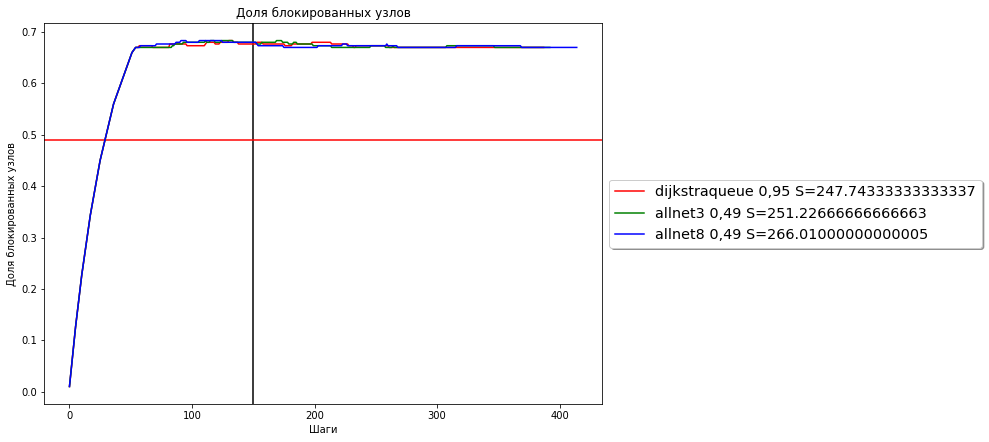

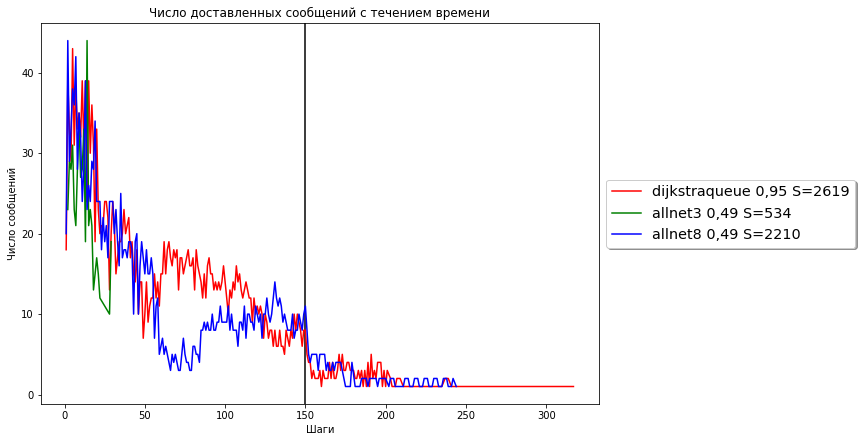

In [6]:
quantity = 300;
log_tags = [
{"tag":  "90623cb2-6daa-446b-9b03-ab09e77e2487", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "030316b2-9847-4af1-9bc4-656da33343ba", "label": "allnet3 0,49", "color": "green"},
{"tag":  "7282562d-63c5-4114-9927-ebaefb440623", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "57147e6d-2bf8-4abe-8d21-c98e92666cb4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "fce91db2-c4a8-4a0d-8b92-fabde1a28b0c", "label": "allnet3 0,49", "color": "green"},
{"tag":  "e101eccf-dfef-4789-980c-e68fb711b3b0", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "c819d524-306c-4b33-be6c-24405ed47076", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b9c5a7e5-b379-4370-8c9d-8187b074ac11", "label": "allnet3 0,49", "color": "green"},
{"tag":  "fac09ecf-b547-4cb0-afb9-b9d6d4644b50", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "1463c499-560a-4718-8d97-b791fea46948", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f4a5c814-ef0c-471e-8a56-47fff16eb37c", "label": "allnet3 0,49", "color": "green"},
{"tag":  "75433cc3-6e20-4830-96b0-0c82e806247a", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

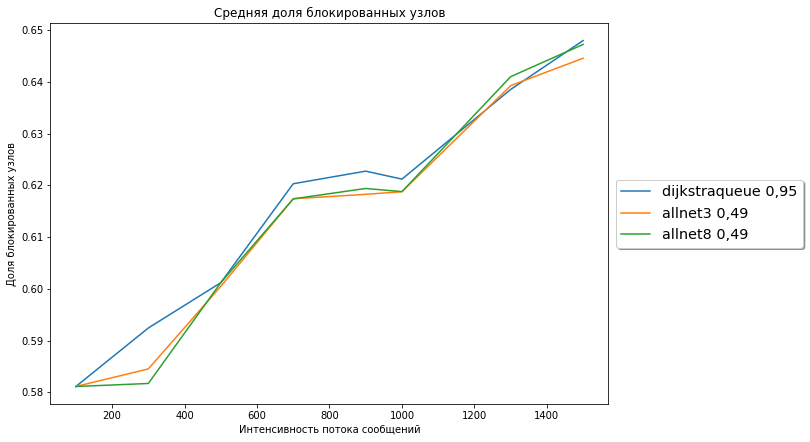

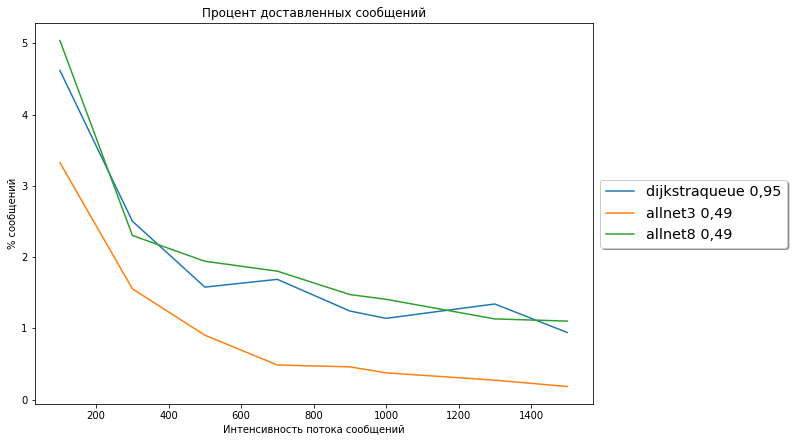

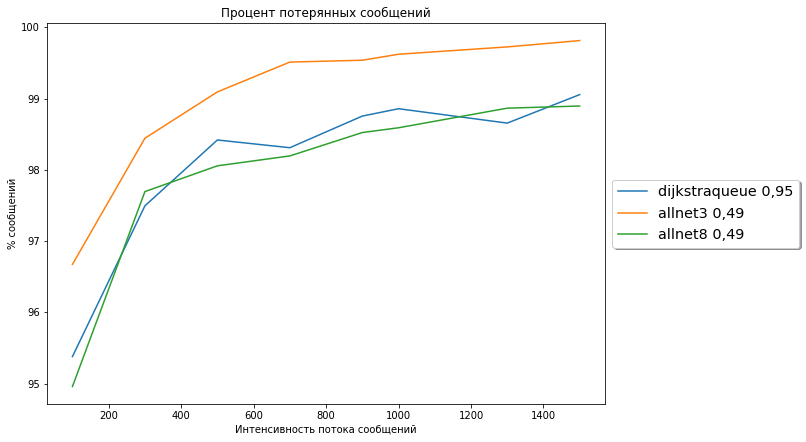

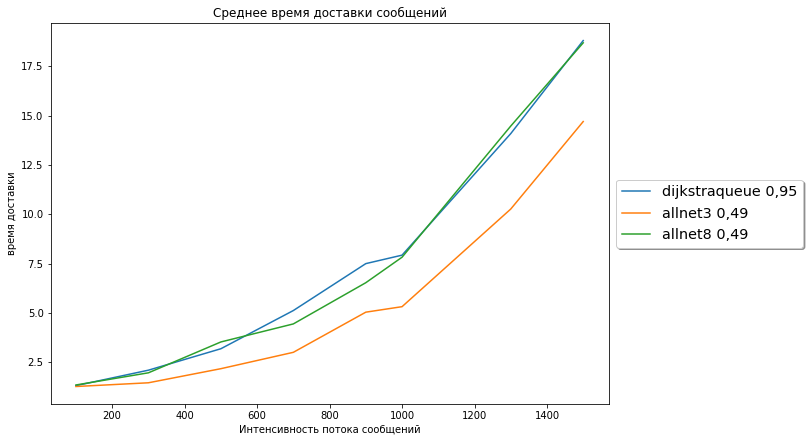

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.615689
allnet3 0,49          0.613052
allnet8 0,49          0.613481

dijkstraqueue 0,95    98.116931
allnet3 0,49          99.053740
allnet8 0,49          97.973609

dijkstraqueue 0,95    7.514333
allnet3 0,49          5.413489
allnet8 0,49          7.359828
